<a href="https://colab.research.google.com/github/mgiorgi13/brain_tumor_classifier/blob/mattia/ResNet_50_pretrained_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [12]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

from keras.applications import VGG16
from keras.models import Sequential ,load_model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D


## Google Drive connection

In [2]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utilities

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import backend as K
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# Percorso della cartella "unified" che contiene le sottocartelle delle classi
base_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

models_path = "/content/drive/MyDrive/BrainTumorDataset/Models"
cnn_results_path = os.path.join(models_path, 'CNN')
vgg16_results_path = os.path.join(models_path, 'VGG16')
resnet50_results_path = os.path.join(models_path, 'ResNet50')
inceptionv3_results_path = os.path.join(models_path, 'InceptionV3')
# actual_results_path = vgg16_results_path

def set_seed ():
	''' 
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)     

# Definisci le dimensioni delle immagini
image_size = 224
batch_size = 32

# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
     

def show_training_and_validation_performance(history,path):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.savefig(path)

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, type, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param type: type of model, CNN, VGG16, ResNet50, InceptionV3
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = os.path.join(models_path, type + '/' + model_name + '.h5') 
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=True)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history,os.path.join(models_path, type + '/' + model_name + '_validation.png'))

def plot_roc_curve(y_true, y_pred, n_classes, class_labels, model_name, type):

    # Converti le etichette di classe in formato binario
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # Calcola i tassi di FPR e TPR per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']  # Colori per le diverse classi

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(models_path, type + '/' + model_name + '_ROC.png'))
    plt.show()

def evaluate_model (model, test_generator, model_name, type):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''
	labels_d= ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())
	
	print("Classification report: ")
	# create and show classification report
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# save classification report
	with open(os.path.join(models_path, type + '/' + model_name + '_classification_report.txt'), 'w') as f:
		f.write(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))

	# create and show confusion matrix	
	cm = confusion_matrix(y_true, y_pred)	
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
	disp.plot(xticks_rotation=45)
	
	# save confusion matrix
	plt.savefig(os.path.join(models_path, type, model_name + '_confusion_matrix.png'), bbox_inches='tight', pad_inches=0.1)
	plt.show()

	plot_roc_curve(y_true, y_score, 4, class_labels, model_name, type)

def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index 

def clear(model):
	del model
	K.clear_session() 

set_seed ()

Found 4520 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


## Load ResNet-50

In [4]:
# Carica il modello ResNet50 pre-addestrato, senza l'ultimo strato fully connected
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

## Experiment 1
ResNet-50 + dense layer 256 neuron

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 256)               33554688  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 57,143,428
Trainable params: 33,555,716
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 3.7762 - accuracy: 0.4354
Epoch 1: val_loss improved from inf to 1.93684, saving model to /conte

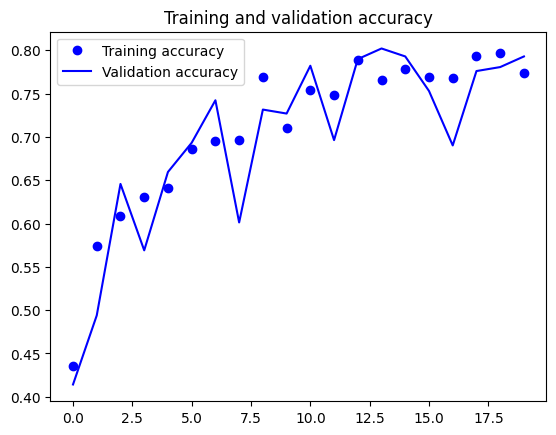

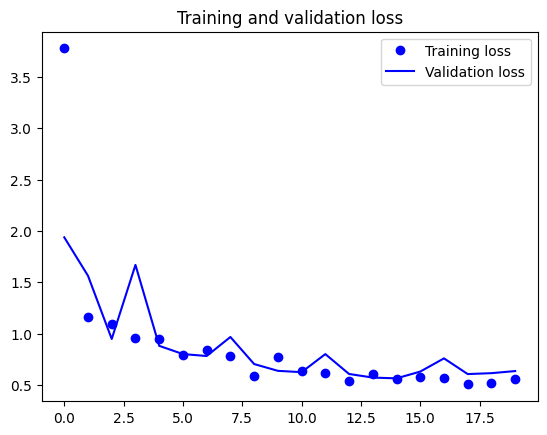

In [5]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_256")

evaluate_model(model, test_generator, "ResNet-50_256", "ResNet50")

### suggerimento : 

Se la curva di validation dell'accuracy oscilla, alza e abbassa, potrebbe essere un segnale di overfitting. Questo perché il modello sta diventando troppo complesso e si sta adattando troppo bene ai dati di addestramento. Inoltre, l'oscillazione potrebbe essere dovuta alla presenza di troppa varianza nei dati di addestramento o ad una dimensione insufficiente del dataset di addestramento.

Un altro possibile motivo per cui la curva di validation dell'accuracy oscilla potrebbe essere la sensibilità del modello alla configurazione dei dati di addestramento e di validazione. Ad esempio, se la suddivisione dei dati di addestramento e di validazione non è stata effettuata in modo casuale, potrebbe esserci una certa correlazione tra i dati di addestramento e quelli di validazione che potrebbe influenzare la performance del modello.

In generale, se la curva di validation dell'accuracy oscilla, alza e abbassa, si consiglia di utilizzare tecniche di regolarizzazione come dropout o l1/l2 regularization per ridurre l'overfitting. Inoltre, potrebbe essere utile aumentare la dimensione del dataset di addestramento o utilizzare tecniche di data augmentation per aumentare la varietà dei dati di addestramento. Infine, è possibile considerare l'utilizzo di modelli più semplici o l'ottimizzazione dei parametri del modello per migliorare le performance.

21/21 [==============================] - 116s 6s/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.7360    0.7838    0.7592       185
meningioma_tumor     0.7397    0.5775    0.6486       187
        no_tumor     0.7479    0.8900    0.8128       100
 pituitary_tumor     0.8895    0.9389    0.9135       180

        accuracy                         0.7837       652
       macro avg     0.7783    0.7976    0.7835       652
    weighted avg     0.7813    0.7837    0.7783       652



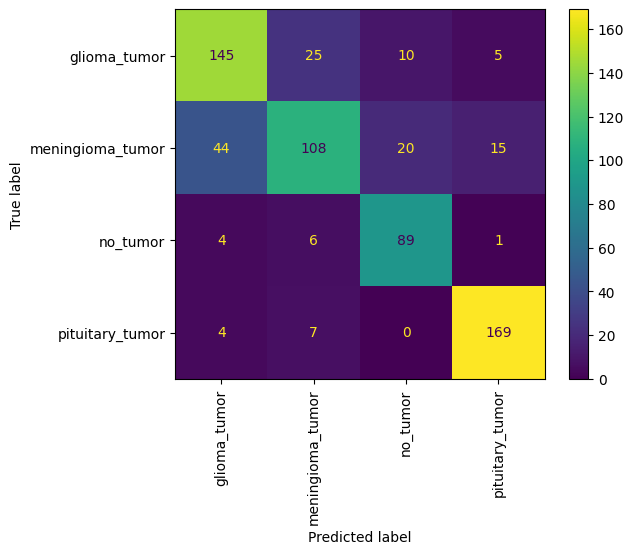

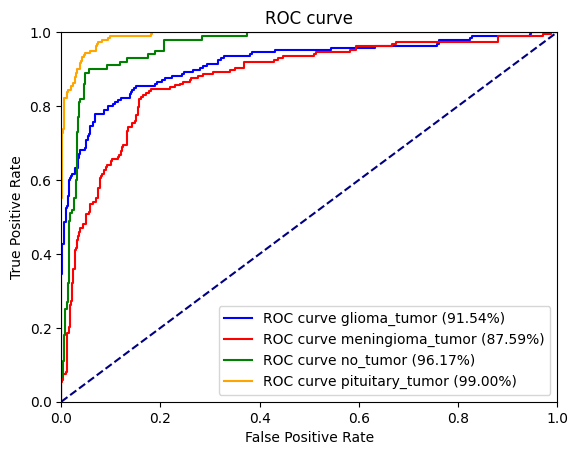

In [6]:
model = load_model(dataset_path + "/ResNet-50_256.h5")
# Valuta il modello
evaluate_model(model,test_generator)

## Experiment 2
ResNet-50 + dense layer 256 neurons and dropout 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               33554688  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 57,143,428
Trainable params: 33,555,716
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [============

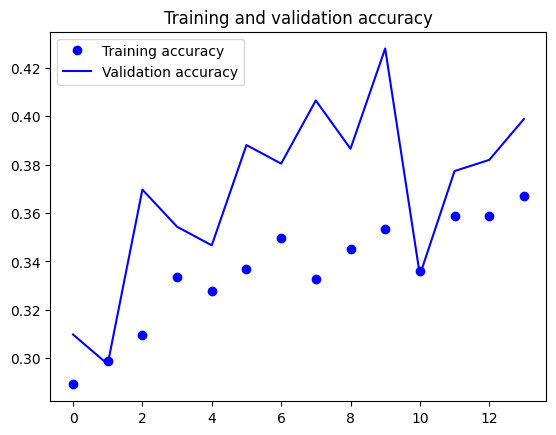

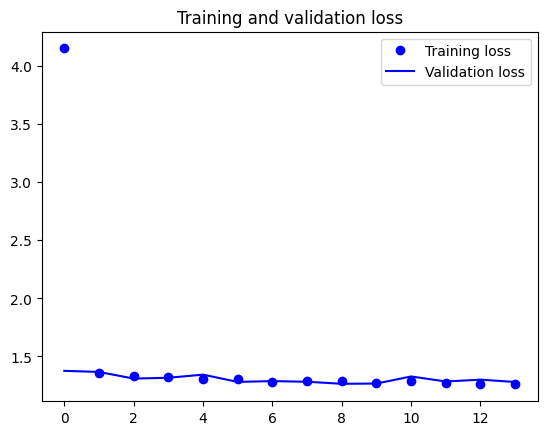

In [7]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,'ResNet50', "ResNet-50_256_dropout")

evaluate_model(model, test_generator, "ResNet-50_256_dropout", "ResNet50")

21/21 [==============================] - 5s 188ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.2727    0.0324    0.0580       185
meningioma_tumor     0.5143    0.0963    0.1622       187
        no_tumor     0.5567    0.5400    0.5482       100
 pituitary_tumor     0.3394    0.9389    0.4985       180

        accuracy                         0.3788       652
       macro avg     0.4208    0.4019    0.3167       652
    weighted avg     0.4040    0.3788    0.2847       652



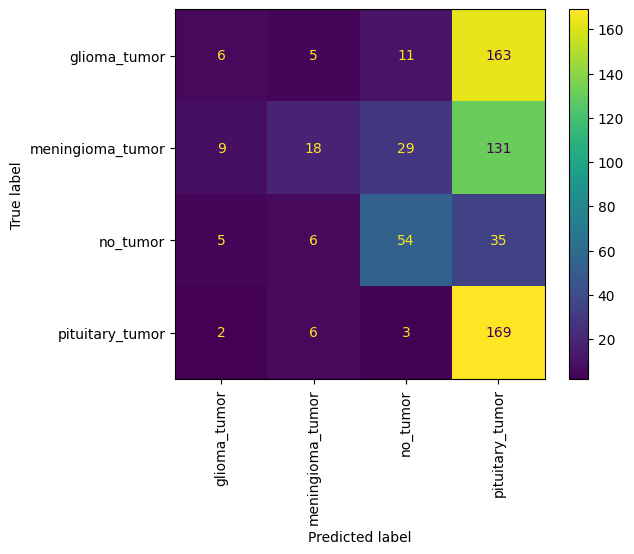

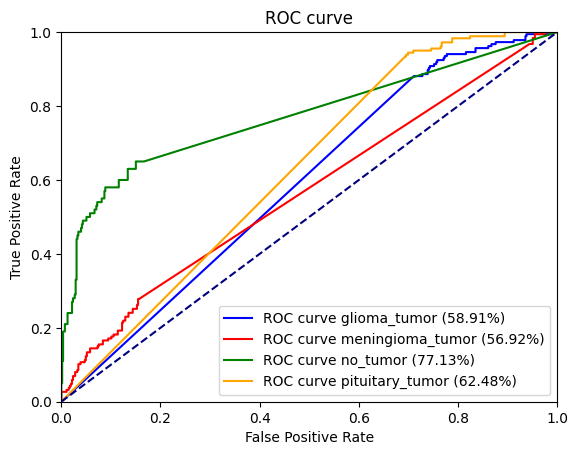

In [8]:
model = load_model(dataset_path + "/ResNet-50_256_dropout.h5")
# Evaluate model
evaluate_model(model,test_generator)

### suggerimento: 
Se dopo aver applicato il dropout la curva di validazione è più alta di quella di training, potrebbe essere un segnale di underfitting, ovvero il modello non è abbastanza complesso per adattarsi ai dati di training.

Il dropout è una tecnica di regolarizzazione che aiuta a prevenire l'overfitting. Essa consiste nel "spegnere" in modo casuale alcuni neuroni durante l'addestramento, in modo da forzare la rete a trovare più vie per rappresentare le relazioni tra le variabili di input.

Se la curva di validazione è più alta di quella di training dopo l'applicazione del dropout, potrebbe significare che la rete non è abbastanza complessa per adattarsi ai dati di training. In questo caso, si potrebbe provare ad aumentare la complessità della rete, aggiungendo più strati o più neuroni ai layer esistenti. In alternativa, si potrebbe provare ad aumentare la dimensione del dataset di training per avere più dati con cui addestrare la rete.

## Experiment 3
ResNet-50 + dense layer 512 neuron and dropout

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               67109376  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 90,699,140
Trainable params: 67,111,428
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [============

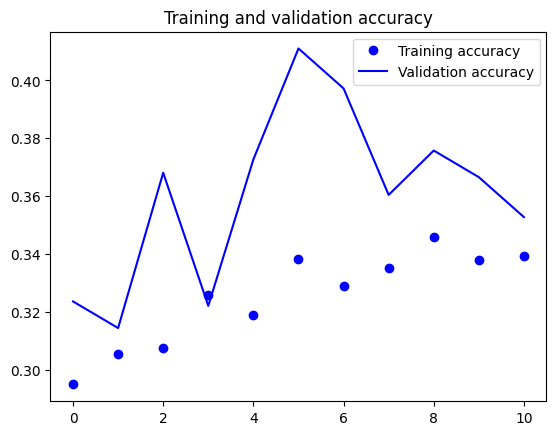

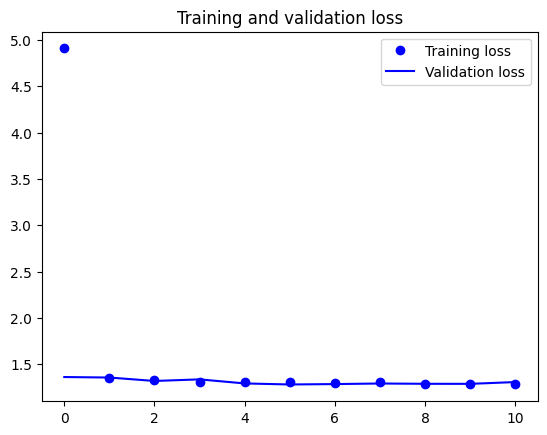

21/21 [==============================] - 5s 190ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.0000    0.0000    0.0000       185
meningioma_tumor     0.3684    0.0374    0.0680       187
        no_tumor     0.5763    0.3400    0.4277       100
 pituitary_tumor     0.3084    0.9833    0.4695       180

        accuracy                         0.3344       652
       macro avg     0.3133    0.3402    0.2413       652
    weighted avg     0.2792    0.3344    0.2147       652



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


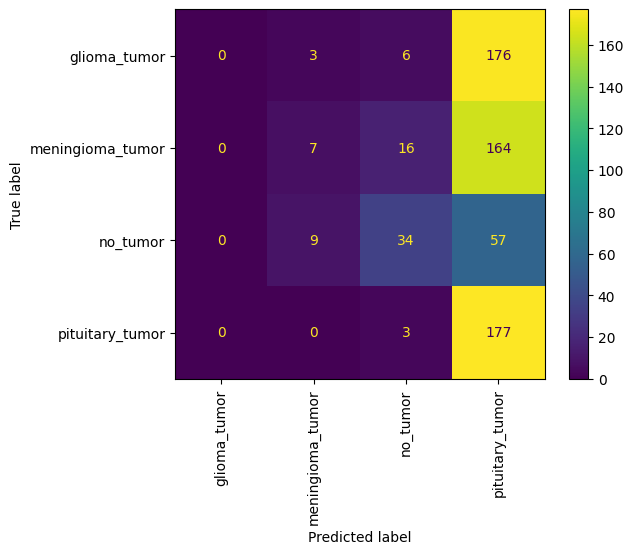

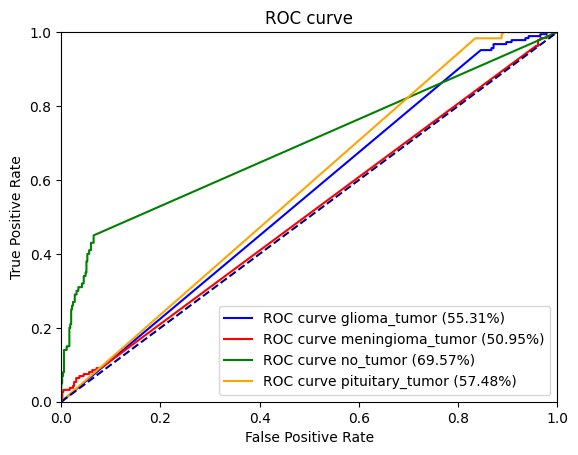

In [9]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_512_dropout")

# Evaluate model
evaluate_model(model,test_generator, "ResNet-50_512_dropout", "ResNet50")

In [10]:
# unfreeze first block of base_model to make fine tuning

## Experiment 4
ResNet-50 + dense layer 512 neuron and GlobalAveragePooling2D

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 1.3164 - accuracy: 0.4108
Epo

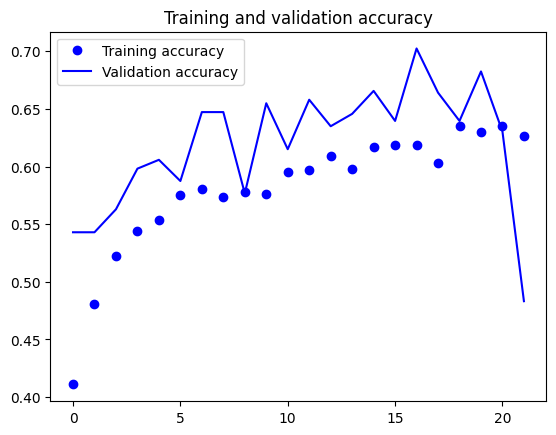

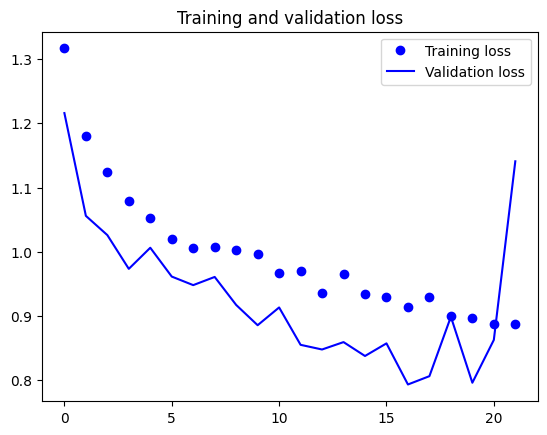

21/21 [==============================] - 6s 235ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.5136    0.8162    0.6305       185
meningioma_tumor     0.6727    0.1979    0.3058       187
        no_tumor     0.3381    0.9500    0.4987       100
 pituitary_tumor     0.9545    0.1167    0.2079       180

        accuracy                         0.4663       652
       macro avg     0.6197    0.5202    0.4107       652
    weighted avg     0.6541    0.4663    0.4005       652



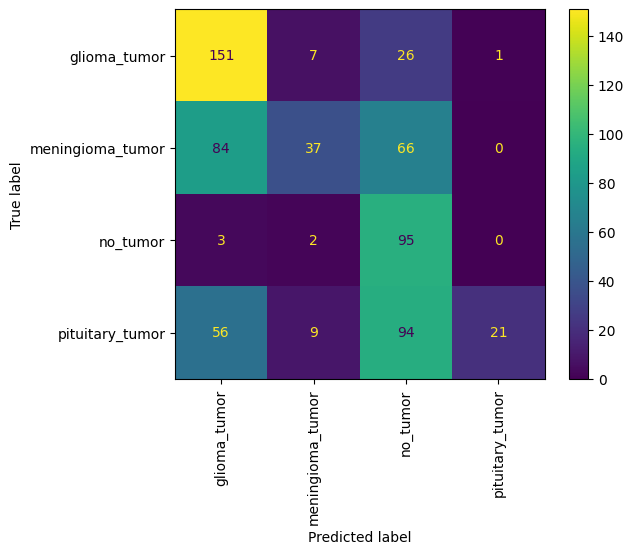

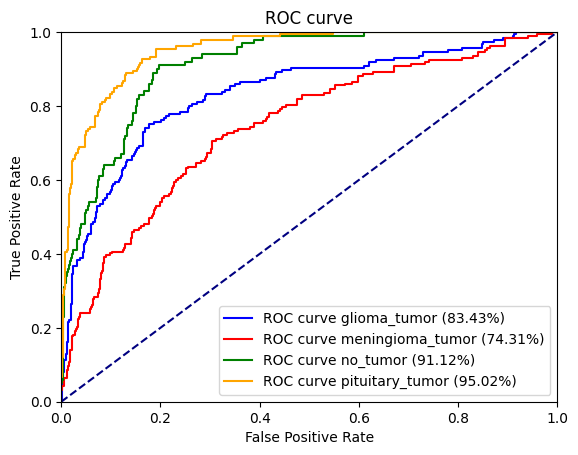

In [13]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_512_globAvgPool")

# Evaluate model
evaluate_model(model,test_generator, "ResNet-50_512_globAvgPool", "ResNet50")

In [ ]:
# unfreeze first block of base_model to make fine tuning

## Experiment 5
ResNet-50 + dense layer 512 neuron and GlobalAveragePooling2D with dropout

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
__________________________________

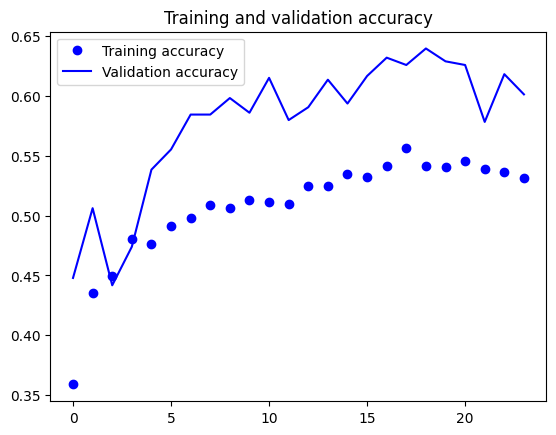

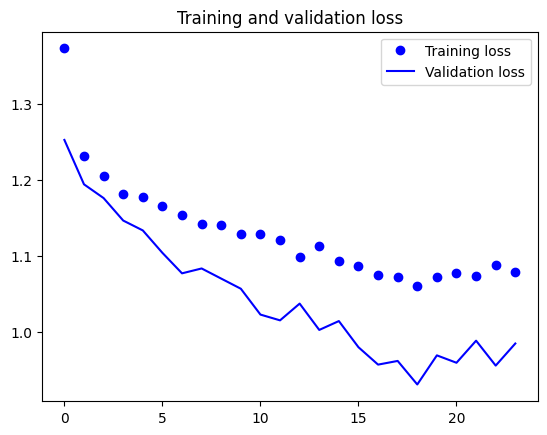

21/21 [==============================] - 6s 242ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.5929    0.3622    0.4497       185
meningioma_tumor     0.4531    0.5936    0.5139       187
        no_tumor     0.5304    0.6100    0.5674       100
 pituitary_tumor     0.7318    0.7278    0.7298       180

        accuracy                         0.5675       652
       macro avg     0.5771    0.5734    0.5652       652
    weighted avg     0.5816    0.5675    0.5635       652



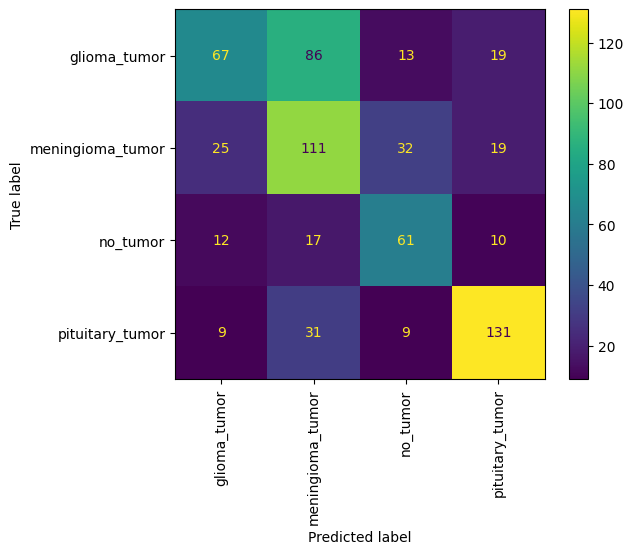

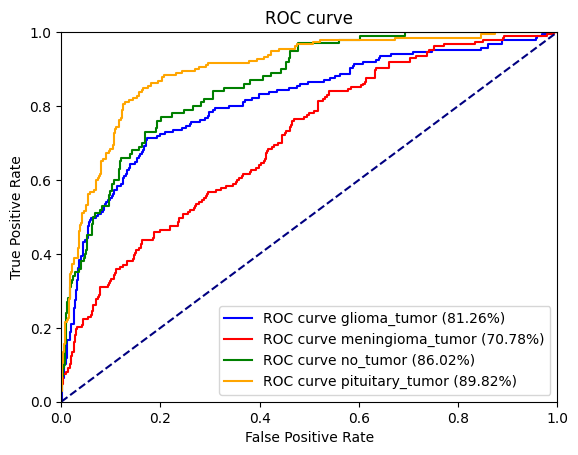

In [14]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_512_globAvgPool_dropout")

# Evaluate model
evaluate_model(model,test_generator, "ResNet-50_512_globAvgPool_dropout", "ResNet50")

In [ ]:
# unfreeze first block of base_model to make fine tuning

## Experiment 6
ResNet-50 + dense layer 128 neuron

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 128)               262272    
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 23,850,500
Trainable params: 262,788
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
141/142 [============================>.] - ETA: 0s - loss: 1.2881 - accuracy: 0.3969
Epoch

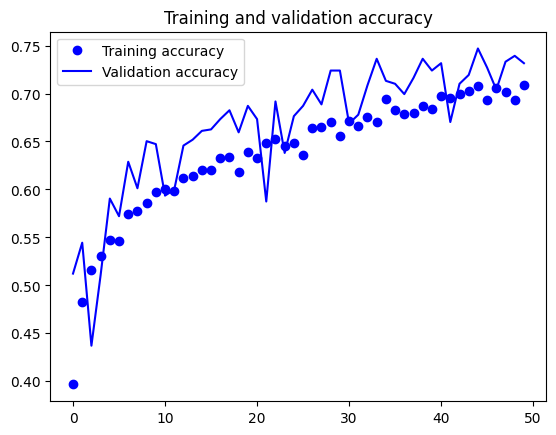

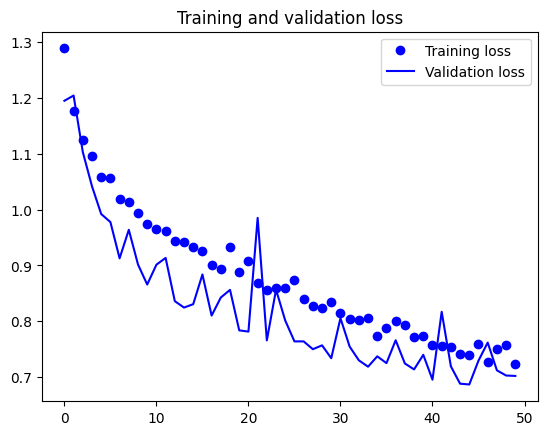

In [15]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_128_GlAvgPool")

# Evaluate model
evaluate_model(model,test_generator, "ResNet-50_128_GlAvgPool", "ResNet50")

### suggerimento : 

Se la curva di validation dell'accuracy oscilla, alza e abbassa, potrebbe essere un segnale di overfitting. Questo perché il modello sta diventando troppo complesso e si sta adattando troppo bene ai dati di addestramento. Inoltre, l'oscillazione potrebbe essere dovuta alla presenza di troppa varianza nei dati di addestramento o ad una dimensione insufficiente del dataset di addestramento.

Un altro possibile motivo per cui la curva di validation dell'accuracy oscilla potrebbe essere la sensibilità del modello alla configurazione dei dati di addestramento e di validazione. Ad esempio, se la suddivisione dei dati di addestramento e di validazione non è stata effettuata in modo casuale, potrebbe esserci una certa correlazione tra i dati di addestramento e quelli di validazione che potrebbe influenzare la performance del modello.

In generale, se la curva di validation dell'accuracy oscilla, alza e abbassa, si consiglia di utilizzare tecniche di regolarizzazione come dropout o l1/l2 regularization per ridurre l'overfitting. Inoltre, potrebbe essere utile aumentare la dimensione del dataset di addestramento o utilizzare tecniche di data augmentation per aumentare la varietà dei dati di addestramento. Infine, è possibile considerare l'utilizzo di modelli più semplici o l'ottimizzazione dei parametri del modello per migliorare le performance.

21/21 [==============================] - 5s 200ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.7120    0.7081    0.7100       185
meningioma_tumor     0.6528    0.5027    0.5680       187
        no_tumor     0.6612    0.8000    0.7240       100
 pituitary_tumor     0.7833    0.8833    0.8303       180

        accuracy                         0.7117       652
       macro avg     0.7023    0.7235    0.7081       652
    weighted avg     0.7069    0.7117    0.7046       652



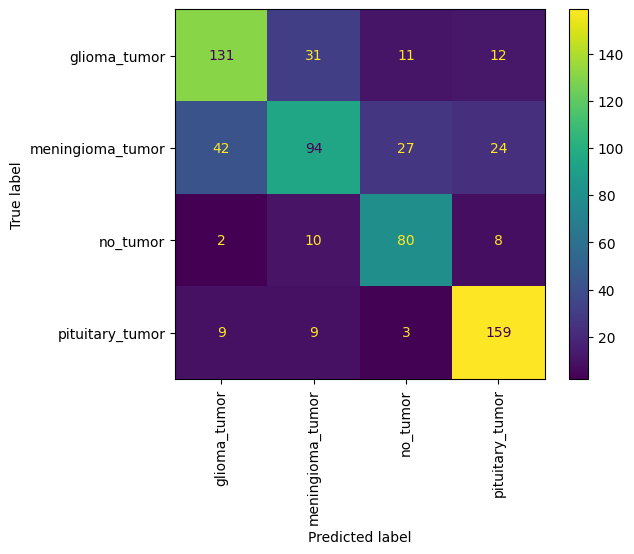

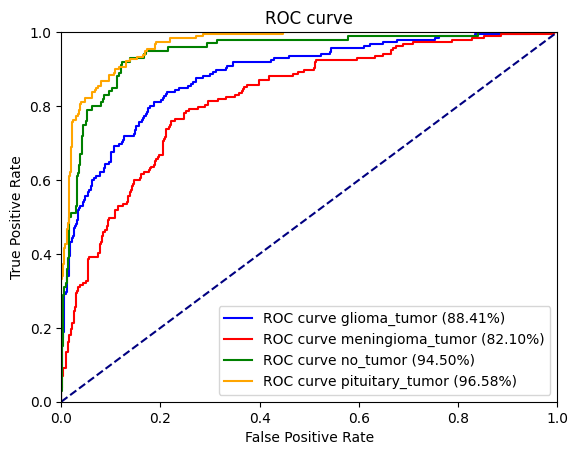

In [16]:
model = load_model(dataset_path + "/ResNet-50_128_GlAvgPool.h5")
# Valuta il modello
evaluate_model(model,test_generator)

## Experiment 7
ResNet-50 + 2 dense layer 128 neuron and dropout with global average pooling

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 4)                 516       
                                                      

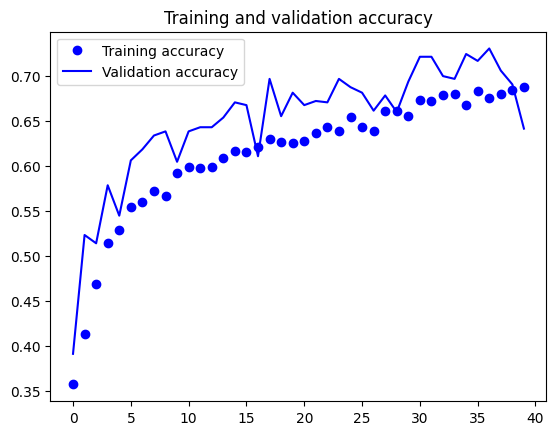

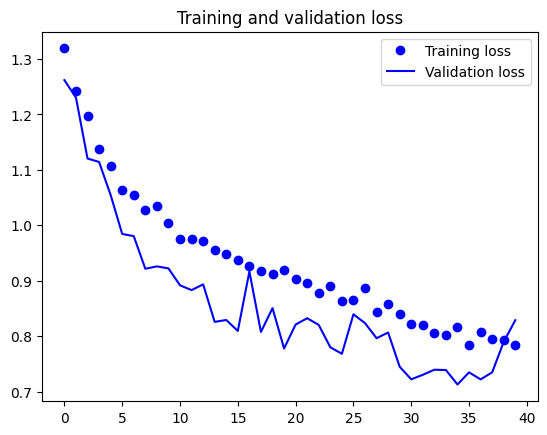

In [17]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_128_128_GlAvgPool")

# Evaluate model
evaluate_model(model,test_generator, "ResNet-50_128_128_GlAvgPool", "ResNet50")

### suggerimento : 

Se la curva di validation dell'accuracy oscilla, alza e abbassa, potrebbe essere un segnale di overfitting. Questo perché il modello sta diventando troppo complesso e si sta adattando troppo bene ai dati di addestramento. Inoltre, l'oscillazione potrebbe essere dovuta alla presenza di troppa varianza nei dati di addestramento o ad una dimensione insufficiente del dataset di addestramento.

Un altro possibile motivo per cui la curva di validation dell'accuracy oscilla potrebbe essere la sensibilità del modello alla configurazione dei dati di addestramento e di validazione. Ad esempio, se la suddivisione dei dati di addestramento e di validazione non è stata effettuata in modo casuale, potrebbe esserci una certa correlazione tra i dati di addestramento e quelli di validazione che potrebbe influenzare la performance del modello.

In generale, se la curva di validation dell'accuracy oscilla, alza e abbassa, si consiglia di utilizzare tecniche di regolarizzazione come dropout o l1/l2 regularization per ridurre l'overfitting. Inoltre, potrebbe essere utile aumentare la dimensione del dataset di addestramento o utilizzare tecniche di data augmentation per aumentare la varietà dei dati di addestramento. Infine, è possibile considerare l'utilizzo di modelli più semplici o l'ottimizzazione dei parametri del modello per migliorare le performance.

21/21 [==============================] - 5s 186ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.7120    0.7081    0.7100       185
meningioma_tumor     0.6528    0.5027    0.5680       187
        no_tumor     0.6612    0.8000    0.7240       100
 pituitary_tumor     0.7833    0.8833    0.8303       180

        accuracy                         0.7117       652
       macro avg     0.7023    0.7235    0.7081       652
    weighted avg     0.7069    0.7117    0.7046       652



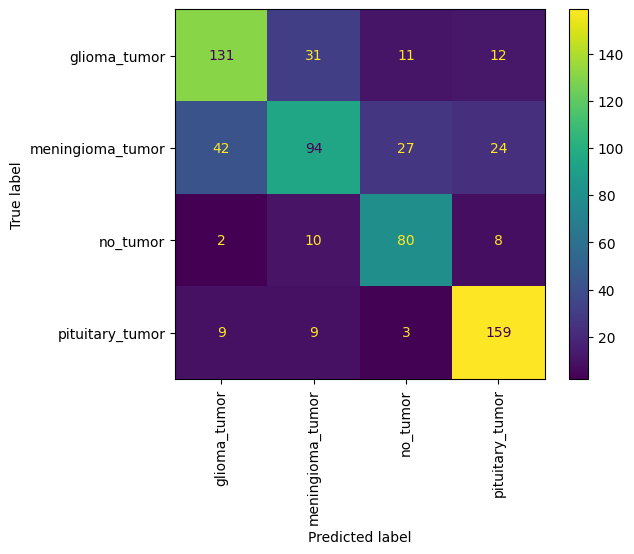

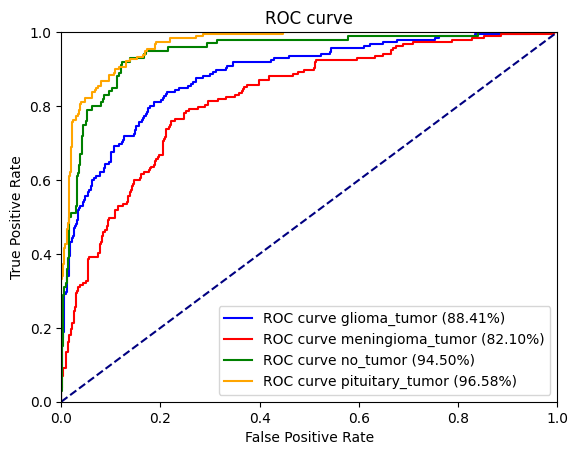

In [18]:
model = load_model(dataset_path + "/ResNet-50_128_GlAvgPool.h5")
# Valuta il modello
evaluate_model(model,test_generator)